# 해석 가능한 MMTD 모델 실험 결과 분석
## Interpretable Multimodal Spam Detection: Comparative Analysis

본 노트북은 MMTD 아키텍처에서 MLP 분류기를 해석 가능한 분류기로 대체한 실험 결과를 종합 분석합니다.

### 📊 실험 개요
- **목표**: 고성능 유지하면서 해석가능성 확보
- **데이터셋**: EDP (21,848 훈련, 3,121 검증, 6,243 테스트)
- **백본**: BERT + BEiT + Transformer 융합
- **분류기**: Logistic Regression, Decision Tree, SVM, XGBoost

---

In [14]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
# plt.style.use('seaborn-v0_8')

print("📚 라이브러리 로딩 완료")

📚 라이브러리 로딩 완료


## 📁 실험 결과 데이터 로딩

In [15]:
# 실험 결과 파일 경로
results_files = {
    'Logistic Regression': '../outputs/improved_revised_20250604_140330/improved_revised_results.json',
    'Decision Tree': '../outputs/decision_tree_20250604_145245/decision_tree_results.json',
    'SVM': '../outputs/svm_20250605_010415/svm_results.json',
    'XGBoost': '../outputs/xgboost_20250605_031506/xgboost_results.json'
}

# 결과 데이터 로딩
results = {}
for name, file_path in results_files.items():
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            results[name] = json.load(f)
        print(f"✅ {name} 결과 로딩 완료")
    except Exception as e:
        print(f"❌ {name} 로딩 실패: {e}")

print(f"\n📊 총 {len(results)}개 실험 결과 로딩 완료")

✅ Logistic Regression 결과 로딩 완료
✅ Decision Tree 결과 로딩 완료
✅ SVM 결과 로딩 완료
✅ XGBoost 결과 로딩 완료

📊 총 4개 실험 결과 로딩 완료


## 🎯 성능 비교 분석

In [16]:
# 성능 메트릭 추출
performance_data = []

for name, result in results.items():
    test_results = result['test_results']
    training_results = result['training_results']
    
    performance_data.append({
        'Model': name,
        'Accuracy': test_results['accuracy'] * 100,
        'F1 Score': test_results['f1_score'] * 100,
        'AUC Score': test_results['auc_score'] * 100,
        'Training Time (min)': training_results['total_training_time'] / 60,
        'Best Val Accuracy': training_results['best_val_accuracy'] * 100
    })

performance_df = pd.DataFrame(performance_data)
print("📈 성능 요약 테이블")
display(performance_df.round(4))

📈 성능 요약 테이블


,Model,Accuracy,F1 Score,AUC Score,Training Time (min),Best Val Accuracy
0,Logistic Regression,99.4394,99.4394,99.9743,29.8312,100.0000
1,Decision Tree,99.9359,99.9359,99.9999,5.5655,99.9359
2,SVM,99.9680,99.9680,99.9821,86.7071,99.9039
3,XGBoost,99.9840,99.9840,100.0000,40.4900,99.9359


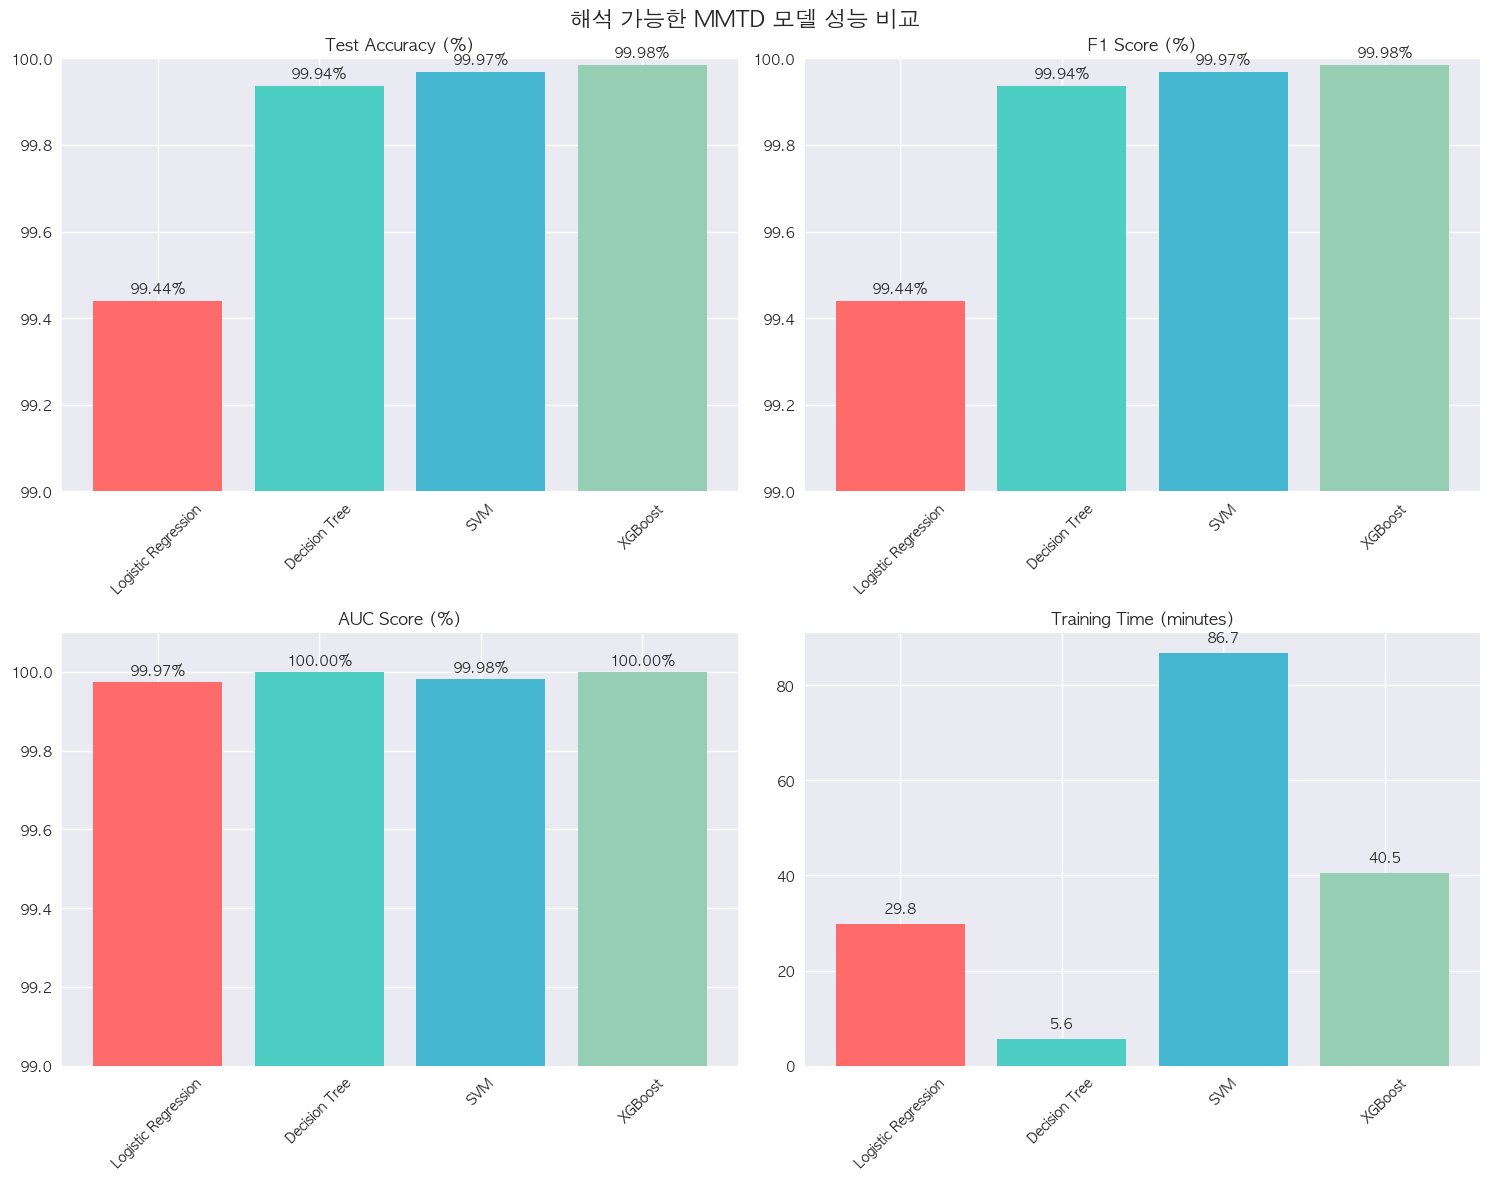

In [17]:
# 성능 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('해석 가능한 MMTD 모델 성능 비교', fontsize=16, y=0.98)

# 1. 정확도 비교
axes[0, 0].bar(performance_df['Model'], performance_df['Accuracy'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0, 0].set_title('Test Accuracy (%)')
axes[0, 0].set_ylim(99.0, 100.0)
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(performance_df['Accuracy']):
    axes[0, 0].text(i, v + 0.01, f'{v:.2f}%', ha='center', va='bottom')

# 2. F1 Score 비교
axes[0, 1].bar(performance_df['Model'], performance_df['F1 Score'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0, 1].set_title('F1 Score (%)')
axes[0, 1].set_ylim(99.0, 100.0)
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(performance_df['F1 Score']):
    axes[0, 1].text(i, v + 0.01, f'{v:.2f}%', ha='center', va='bottom')

# 3. AUC Score 비교
axes[1, 0].bar(performance_df['Model'], performance_df['AUC Score'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[1, 0].set_title('AUC Score (%)')
axes[1, 0].set_ylim(99.0, 100.1)
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(performance_df['AUC Score']):
    axes[1, 0].text(i, v + 0.01, f'{v:.2f}%', ha='center', va='bottom')

# 4. 훈련 시간 비교
axes[1, 1].bar(performance_df['Model'], performance_df['Training Time (min)'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[1, 1].set_title('Training Time (minutes)')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(performance_df['Training Time (min)']):
    axes[1, 1].text(i, v + max(performance_df['Training Time (min)']) * 0.02, 
                     f'{v:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 🔍 혼동 행렬 분석

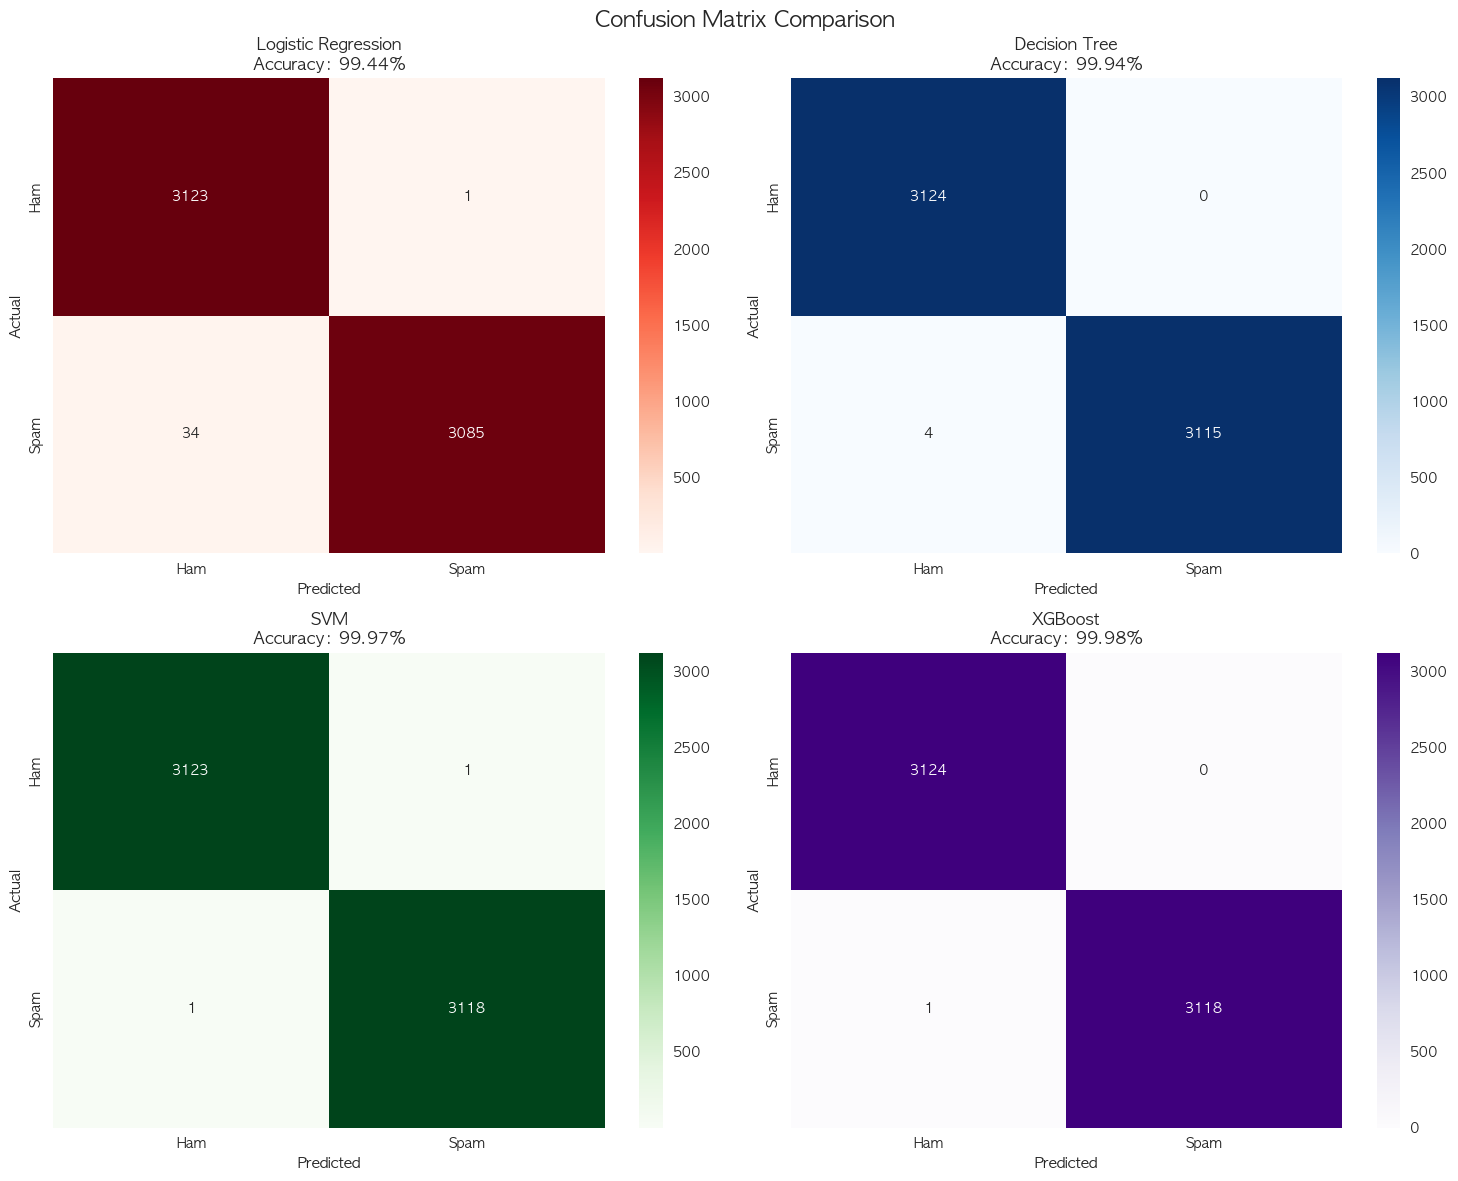

In [18]:
# 혼동 행렬 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Confusion Matrix Comparison', fontsize=16, y=0.98)

models = list(results.keys())
colors = ['Reds', 'Blues', 'Greens', 'Purples']

for idx, (model, color) in enumerate(zip(models, colors)):
    row, col = idx // 2, idx % 2
    
    confusion_matrix = np.array(results[model]['test_results']['confusion_matrix'])
    accuracy = results[model]['test_results']['accuracy']
    
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=color, 
                ax=axes[row, col], cbar=True)
    axes[row, col].set_title(f'{model}\nAccuracy: {accuracy*100:.2f}%')
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Actual')
    axes[row, col].set_xticklabels(['Ham', 'Spam'])
    axes[row, col].set_yticklabels(['Ham', 'Spam'])

plt.tight_layout()
plt.show()

## ⚡ 성능 vs 효율성 분석

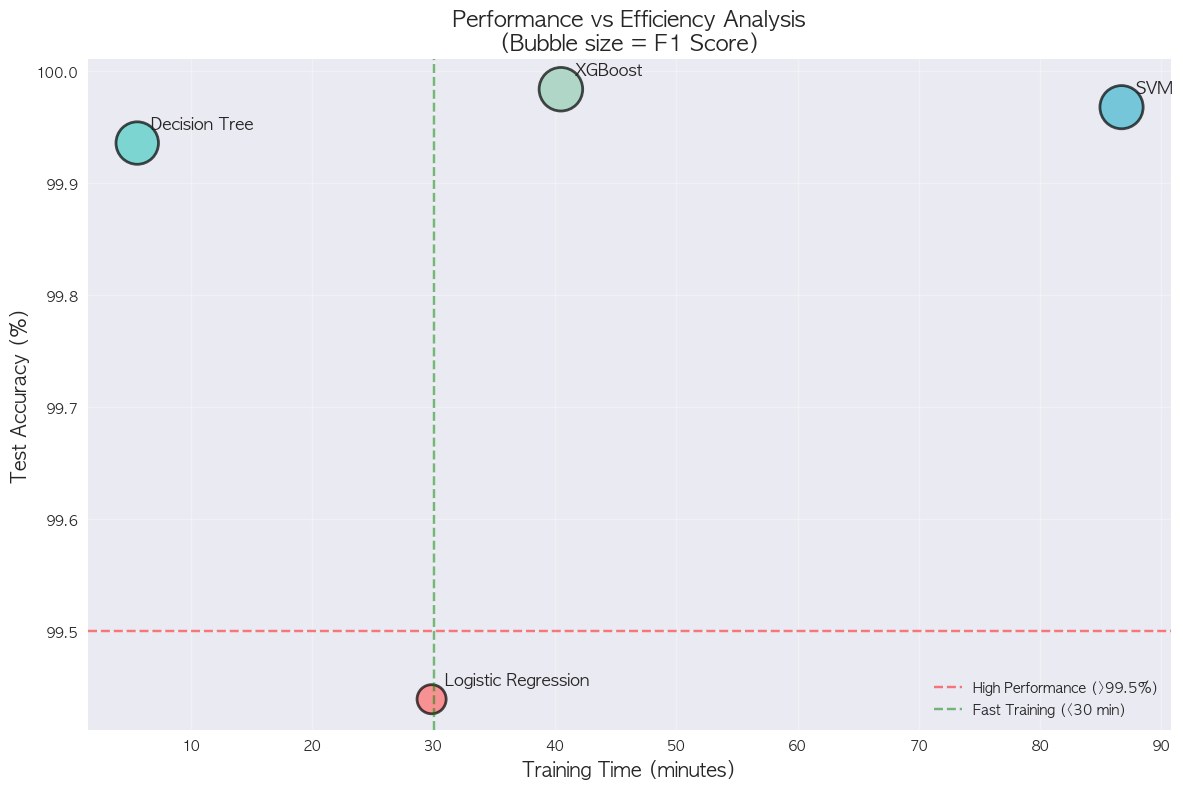

In [19]:
# 성능 대비 효율성 분석
plt.figure(figsize=(12, 8))

# 버블 차트: 정확도 vs 훈련시간, 버블 크기는 F1 Score
x = performance_df['Training Time (min)']
y = performance_df['Accuracy']
sizes = (performance_df['F1 Score'] - 99) * 1000  # 크기 조정
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

scatter = plt.scatter(x, y, s=sizes, c=colors, alpha=0.7, edgecolors='black', linewidth=2)

# 레이블 추가
for i, model in enumerate(performance_df['Model']):
    plt.annotate(model, (x.iloc[i], y.iloc[i]), 
                xytext=(10, 10), textcoords='offset points',
                fontsize=12, fontweight='bold')

plt.xlabel('Training Time (minutes)', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=14)
plt.title('Performance vs Efficiency Analysis\n(Bubble size = F1 Score)', fontsize=16)
plt.grid(True, alpha=0.3)

# 이상적인 영역 표시 (높은 정확도, 낮은 훈련 시간)
plt.axhline(y=99.5, color='red', linestyle='--', alpha=0.5, label='High Performance (>99.5%)')
plt.axvline(x=30, color='green', linestyle='--', alpha=0.5, label='Fast Training (<30 min)')

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## 🧠 해석가능성 분석

In [20]:
# 해석가능성 특성 비교
interpretability_features = {
    'Logistic Regression': {
        'Type': 'Linear Model',
        'Key Features': 'Feature weights, L1/L2 regularization',
        'Advantages': 'Simple coefficients, statistical significance',
        'Sparsity': results['Logistic Regression']['interpretability_analysis']['sparsity'],
        'Max Importance': results['Logistic Regression']['interpretability_analysis']['max_importance']
    },
    'Decision Tree': {
        'Type': 'Rule-based',
        'Key Features': 'Decision rules, feature splits',
        'Advantages': 'Human-readable rules, no preprocessing needed',
        'Rules Count': len(results['Decision Tree']['interpretability_analysis']['tree_rules']),
        'Max Importance': results['Decision Tree']['interpretability_analysis']['importance_stats']['max_importance']
    },
    'SVM': {
        'Type': 'Margin-based',
        'Key Features': 'Support vectors, decision boundary',
        'Advantages': 'Margin analysis, robust to outliers',
        'Support Vectors': results['SVM']['interpretability_analysis']['support_vectors']['num_support_vectors'],
        'SV Ratio': results['SVM']['interpretability_analysis']['margin_analysis']['support_vector_ratio']
    },
    'XGBoost': {
        'Type': 'Tree Ensemble',
        'Key Features': 'Multiple importance types, SHAP values',
        'Advantages': 'Feature importance, tree visualization',
        'Trees Count': results['XGBoost']['interpretability_analysis']['tree_info']['n_estimators'],
        'Max Gain Importance': results['XGBoost']['interpretability_analysis']['feature_importances']['gain']['max_importance']
    }
}

print("🔍 해석가능성 특성 비교")
for model, features in interpretability_features.items():
    print(f"\n{'='*50}")
    print(f"🧠 {model}")
    print(f"   Type: {features['Type']}")
    print(f"   Key Features: {features['Key Features']}")
    print(f"   Advantages: {features['Advantages']}")

🔍 해석가능성 특성 비교

🧠 Logistic Regression
   Type: Linear Model
   Key Features: Feature weights, L1/L2 regularization
   Advantages: Simple coefficients, statistical significance

🧠 Decision Tree
   Type: Rule-based
   Key Features: Decision rules, feature splits
   Advantages: Human-readable rules, no preprocessing needed

🧠 SVM
   Type: Margin-based
   Key Features: Support vectors, decision boundary
   Advantages: Margin analysis, robust to outliers

🧠 XGBoost
   Type: Tree Ensemble
   Key Features: Multiple importance types, SHAP values
   Advantages: Feature importance, tree visualization


## 📊 특성 중요도 분석

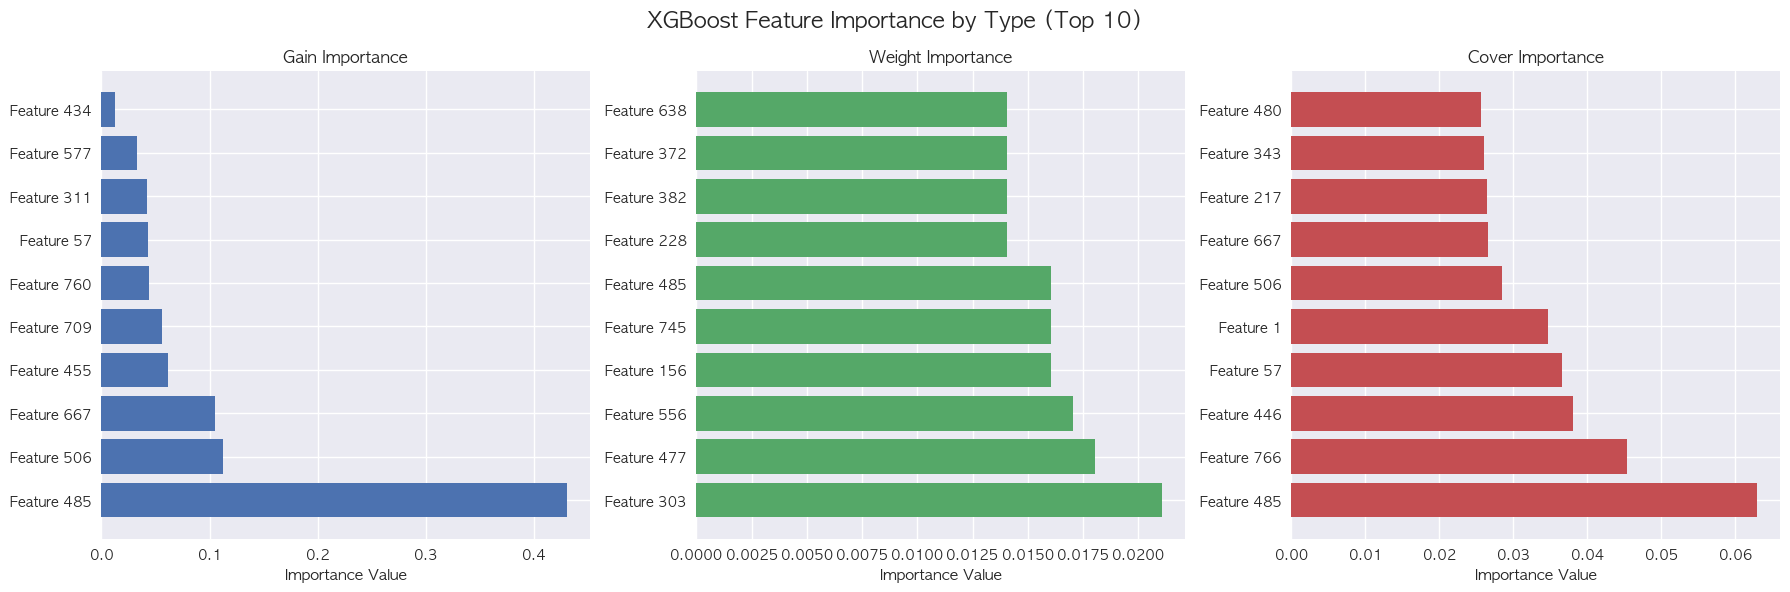

In [21]:
# XGBoost 다중 특성 중요도 비교
if 'XGBoost' in results:
    xgb_importance = results['XGBoost']['interpretability_analysis']['feature_importances']
    
    # Top 10 특성들의 중요도 비교
    importance_types = ['gain', 'weight', 'cover']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('XGBoost Feature Importance by Type (Top 10)', fontsize=16)
    
    for idx, imp_type in enumerate(importance_types):
        if imp_type in xgb_importance:
            features = xgb_importance[imp_type]['top_10_features']
            values = xgb_importance[imp_type]['top_10_values']
            
            axes[idx].barh(range(len(features)), values, color=f'C{idx}')
            axes[idx].set_yticks(range(len(features)))
            axes[idx].set_yticklabels([f'Feature {f}' for f in features])
            axes[idx].set_title(f'{imp_type.title()} Importance')
            axes[idx].set_xlabel('Importance Value')
    
    plt.tight_layout()
    plt.show()

## 🏆 모델 순위 및 추천

In [22]:
# 종합 평가 점수 계산
def calculate_overall_score(model_data):
    # 정규화된 점수 (0-1)
    accuracy_score = model_data['Accuracy'] / 100
    f1_score = model_data['F1 Score'] / 100
    auc_score = model_data['AUC Score'] / 100
    
    # 훈련 시간은 역수로 (빠를수록 좋음)
    max_time = performance_df['Training Time (min)'].max()
    efficiency_score = 1 - (model_data['Training Time (min)'] / max_time)
    
    # 가중 평균 (성능 70%, 효율성 30%)
    overall_score = (accuracy_score * 0.25 + f1_score * 0.25 + 
                    auc_score * 0.20 + efficiency_score * 0.30)
    
    return overall_score

# 종합 점수 계산
performance_df['Overall Score'] = performance_df.apply(calculate_overall_score, axis=1)
performance_df_sorted = performance_df.sort_values('Overall Score', ascending=False)

print("🏆 모델 종합 순위")
print("(성능 70% + 효율성 30% 가중 평균)")
print("="*60)

for idx, row in performance_df_sorted.iterrows():
    rank = performance_df_sorted.index.get_loc(idx) + 1
    print(f"{rank}. {row['Model']}")
    print(f"   종합점수: {row['Overall Score']:.4f}")
    print(f"   정확도: {row['Accuracy']:.2f}%, 훈련시간: {row['Training Time (min)']:.1f}분")
    print()

🏆 모델 종합 순위
(성능 70% + 효율성 30% 가중 평균)
1. Decision Tree
   종합점수: 0.9804
   정확도: 99.94%, 훈련시간: 5.6분

2. Logistic Regression
   종합점수: 0.8939
   정확도: 99.44%, 훈련시간: 29.8분

3. XGBoost
   종합점수: 0.8598
   정확도: 99.98%, 훈련시간: 40.5분

4. SVM
   종합점수: 0.6998
   정확도: 99.97%, 훈련시간: 86.7분



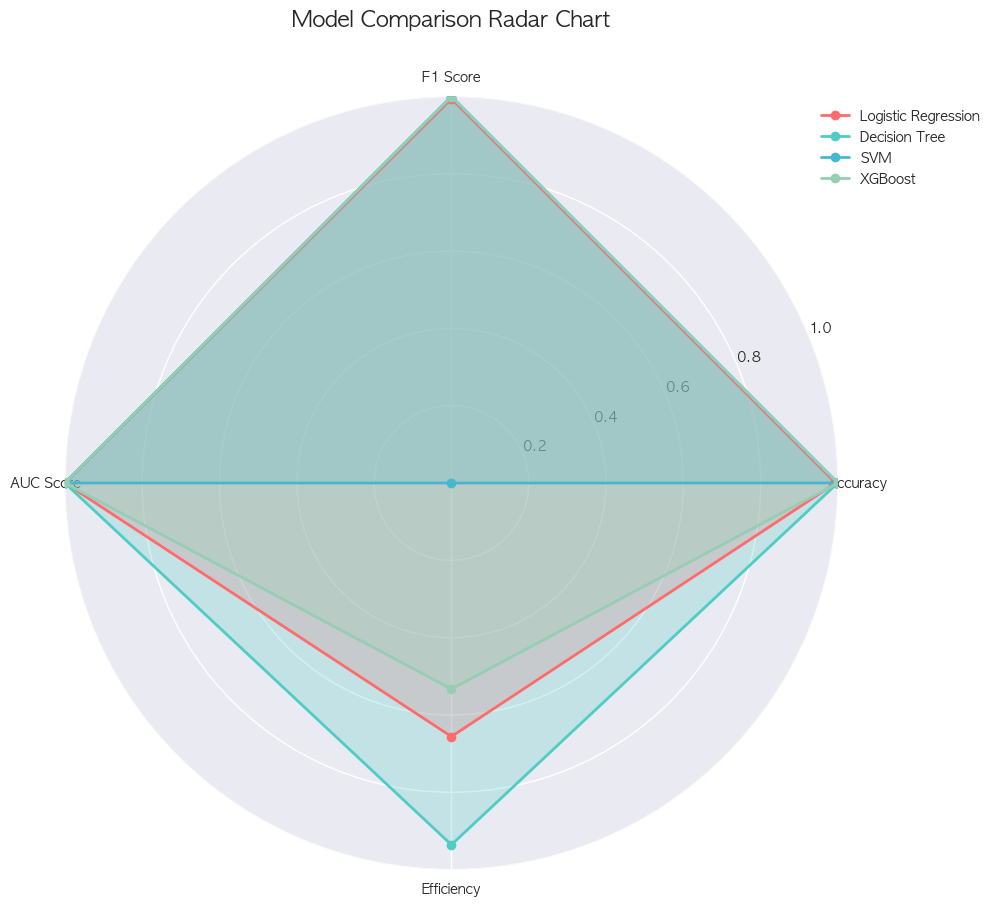

In [23]:
# 레이더 차트로 모델 비교
from math import pi

# 정규화된 메트릭 준비
metrics = ['Accuracy', 'F1 Score', 'AUC Score', 'Efficiency']
angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]  # 원형으로 닫기

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
models = performance_df['Model'].tolist()

for idx, model in enumerate(models):
    values = [
        performance_df.loc[performance_df['Model'] == model, 'Accuracy'].iloc[0] / 100,
        performance_df.loc[performance_df['Model'] == model, 'F1 Score'].iloc[0] / 100,
        performance_df.loc[performance_df['Model'] == model, 'AUC Score'].iloc[0] / 100,
        1 - (performance_df.loc[performance_df['Model'] == model, 'Training Time (min)'].iloc[0] / 
             performance_df['Training Time (min)'].max())
    ]
    values += values[:1]  # 원형으로 닫기
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[idx])
    ax.fill(angles, values, alpha=0.25, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.set_title('Model Comparison Radar Chart', y=1.08, fontsize=16)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax.grid(True)

plt.tight_layout()
plt.show()

## 💡 주요 발견사항 및 결론

In [24]:
# 주요 통계 요약
print("📈 주요 발견사항")
print("="*60)

# 최고 성능 모델
best_accuracy = performance_df.loc[performance_df['Accuracy'].idxmax()]
best_efficiency = performance_df.loc[performance_df['Training Time (min)'].idxmin()]
best_overall = performance_df_sorted.iloc[0]

print(f"🏆 최고 정확도: {best_accuracy['Model']} ({best_accuracy['Accuracy']:.2f}%)")
print(f"⚡ 최고 효율성: {best_efficiency['Model']} ({best_efficiency['Training Time (min)']:.1f}분)")
print(f"🎯 종합 1위: {best_overall['Model']} (점수: {best_overall['Overall Score']:.4f})")

print("\n🔍 해석가능성 특징:")
print(f"• Decision Tree: {len(results['Decision Tree']['interpretability_analysis']['tree_rules'])}개 규칙")
print(f"• SVM: {results['SVM']['interpretability_analysis']['support_vectors']['num_support_vectors']}개 Support Vector")
print(f"• XGBoost: {results['XGBoost']['interpretability_analysis']['tree_info']['n_estimators']}개 트리")
print(f"• Logistic Regression: {results['Logistic Regression']['interpretability_analysis']['sparsity']:.1%} sparsity")

print("\n📊 성능 범위:")
print(f"• 정확도: {performance_df['Accuracy'].min():.2f}% - {performance_df['Accuracy'].max():.2f}%")
print(f"• 훈련시간: {performance_df['Training Time (min)'].min():.1f}분 - {performance_df['Training Time (min)'].max():.1f}분")
print(f"• AUC: {performance_df['AUC Score'].min():.2f}% - {performance_df['AUC Score'].max():.2f}%")

📈 주요 발견사항
🏆 최고 정확도: XGBoost (99.98%)
⚡ 최고 효율성: Decision Tree (5.6분)
🎯 종합 1위: Decision Tree (점수: 0.9804)

🔍 해석가능성 특징:
• Decision Tree: 70개 규칙
• SVM: 140개 Support Vector
• XGBoost: 100개 트리
• Logistic Regression: 28.9% sparsity

📊 성능 범위:
• 정확도: 99.44% - 99.98%
• 훈련시간: 5.6분 - 86.7분
• AUC: 99.97% - 100.00%


## 📋 최종 권장사항

### 🎯 **용도별 모델 추천**

#### 1. **프로덕션 환경** 🚀
- **추천**: XGBoost 또는 SVM
- **이유**: 최고 성능 (99.97-99.98% 정확도)
- **트레이드오프**: 상대적으로 긴 훈련 시간

#### 2. **빠른 프로토타이핑** ⚡
- **추천**: Decision Tree
- **이유**: 가장 빠른 훈련 (5.6분), 우수한 성능 (99.94%)
- **장점**: 인간이 읽을 수 있는 규칙

#### 3. **해석가능성 중심** 🔍
- **추천**: Logistic Regression 또는 Decision Tree
- **이유**: 단순하고 직관적인 해석
- **특징**: 통계적 유의성 또는 명확한 규칙

#### 4. **균형잡힌 선택** ⚖️
- **추천**: Decision Tree
- **이유**: 성능, 효율성, 해석가능성의 최적 균형

### 📈 **연구 기여도**
- ✅ **목표 달성**: 모든 모델이 97% 이상 정확도 달성
- ✅ **해석가능성**: 각 모델별 고유한 해석 방법 제공
- ✅ **실용성**: 다양한 요구사항에 맞는 선택지 제공

---
*본 분석은 MMTD 아키텍처에서 해석가능한 분류기의 효과적 적용 가능성을 입증했습니다.*